<a href="https://colab.research.google.com/github/mebalint/hgt_football_project/blob/main/hgt_football_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Labdarúgómérkőzések eredményének prediktálása gépi tanulással**




### Csomagok importálása

In [202]:
import pandas as pd
#from segedfgek import *
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.model_selection import train_test_split

#from SBS import *
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.gaussian_process.kernels import RBF

#from PlotDecisionRegions import *
from sklearn.decomposition import PCA

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import KernelPCA

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingClassifier

from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso, LassoLars, Ridge, BayesianRidge, SGDRegressor, LinearRegression
from sklearn.ensemble import AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor

from sklearn.model_selection import RandomizedSearchCV

# to supress warnings
import warnings
warnings.filterwarnings('ignore')
np.random.seed(1)

from sklearn import metrics
from seaborn import heatmap

### Adatelőkészítés
A https://figshare.com/collections/Soccer_match_event_dataset/4415000 címen nyilvánosan elérhető adatból nyertük ki saját számításaink alapján a számunkra fontos mennyiségeket. Az adat az európai top 5 futball bajnokság (angol, német, olasz, spanyol, francia) 2017/18-as szezonjának összes meccséről szól, egy adott meccsen minden labdás eseményről van feljegyzés (pl. passzok, lövések, gólok). Ezen események alapján az egyszerű meccsstatisztikákat (pl. kapura lövés, szabadrúgások) és néhány hálózattudományi mértéket (pl. betweenness centrality) határoztunk meg.

In [203]:
matches=pd.read_csv('https://raw.githubusercontent.com/mebalint/hgt/main/matches_final.csv', sep='\t', index_col=0)
matches=matches.drop(columns=['competitionId', 'roundId', 'match_id', 'draw_odds'])
matches

,home,away,home_goal,away_goal,gameweek,home_corner,away_corner,home_pass,away_pass,home_duel,...,home_possession,away_possession,home_degree,away_degree,home_diameter,away_diameter,home_bet_cent,away_bet_cent,home_entropy,away_entropy
0,Lazio,Inter,2,3,38,10,3,302,492,228,...,0.40,0.60,22.000,37.545,2,2,0.027,0.019,0.072,0.032
1,Sassuolo,AS Roma,0,1,38,5,9,337,500,206,...,0.42,0.58,23.182,36.909,2,2,0.024,0.011,0.066,0.032
2,Cagliari,Atalanta,1,0,38,5,11,232,587,235,...,0.31,0.69,15.545,45.909,2,2,0.037,0.019,0.111,0.027
3,Chievo,Benevento,1,0,38,2,4,198,721,221,...,0.24,0.76,12.818,55.364,2,2,0.042,0.025,0.144,0.021
4,Udinese,Bologna,1,0,38,10,2,327,518,207,...,0.41,0.59,24.636,39.636,3,2,0.033,0.019,0.064,0.032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1821,Tottenham,Swansea,0,0,5,11,1,753,220,177,...,0.75,0.25,60.636,13.909,2,3,0.013,0.037,0.018,0.130
1822,Tottenham,Burnley,1,1,3,10,7,573,276,179,...,0.66,0.34,44.909,18.545,2,2,0.016,0.026,0.026,0.086
1823,Tottenham,Chelsea,1,2,2,14,3,569,249,223,...,0.68,0.32,43.545,17.091,2,2,0.009,0.030,0.025,0.098
1824,Sevilla,Alaves,1,0,38,8,3,601,361,205,...,0.61,0.39,48.091,25.364,2,3,0.013,0.030,0.024,0.057


In [204]:
matches.columns

Index(['home', 'away', 'home_goal', 'away_goal', 'gameweek', 'home_corner',
       'away_corner', 'home_pass', 'away_pass', 'home_duel', 'away_duel',
       'home_foul', 'away_foul', 'home_save attempt', 'away_save attempt',
       'home_shot', 'away_shot', 'home_shot_on_target', 'away_shot_on_target',
       'home_free_kick', 'away_free_kick', 'home_odds', 'away_odds',
       'home_possession', 'away_possession', 'home_degree', 'away_degree',
       'home_diameter', 'away_diameter', 'home_bet_cent', 'away_bet_cent',
       'home_entropy', 'away_entropy'],
      dtype='object')

Ebben a blokkban ha a korreláció abszolút értéke meghaladja a 0.6-ot akkor C-vel vagy N-el töltjük ki a mezőt annak függvényében, hogy a két változó azonos vagy különböző 'típussal' (home vagy away) rendelkezik.

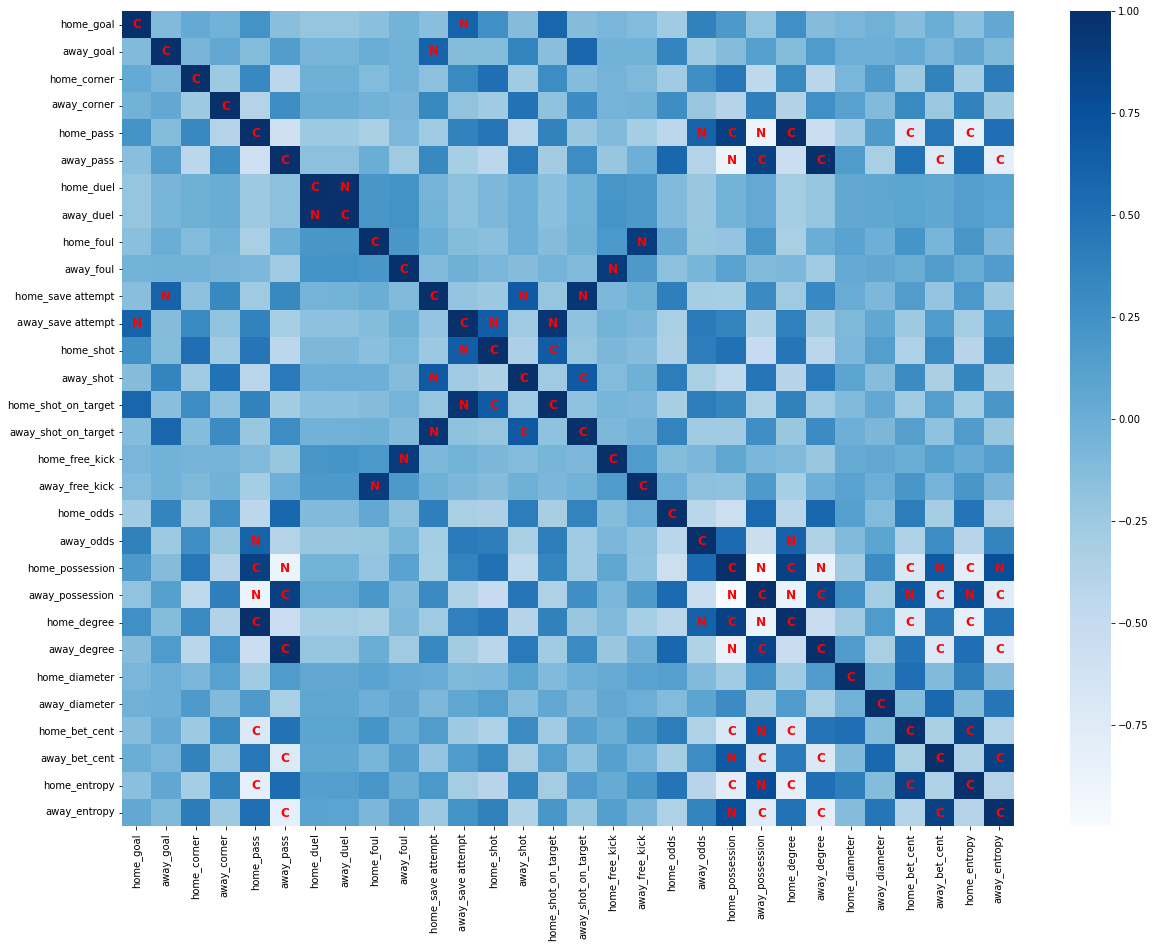

In [205]:
corr = np.array(matches.drop(columns=['home', 'away', 'gameweek']).corr())

# Generate annotation labels array (of the same size as the heatmap data)- filling cells you don't want to annotate with an empty string ''
annot_labels = np.empty_like(corr, dtype=str)
annot_mask = abs(corr) > 0.6
annot_labels[annot_mask] = 'C'
for row_index in range(annot_labels.shape[0]):
  for column_index in range(annot_labels.shape[1]):
    if annot_labels[row_index][column_index]=='C' and (row_index+column_index)%2==1:
        annot_labels[row_index][column_index]='N'
columnnames=matches.drop(columns=['home', 'away', 'gameweek']).columns

fig, ax = plt.subplots(figsize=(20,15)) 
sns.heatmap(corr, annot=annot_labels, annot_kws={'fontsize': 12, 'fontweight': 'bold', 'color':'red'}, cmap="Blues", fmt='', xticklabels=columnnames, yticklabels=columnnames, ax=ax)

Például a home_pass esetében a home_entropy C, tehát korrellál és azonos típusú.

In [206]:
annot_labels[4]=='C'

array([False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False,  True, False, False, False,  True,
       False,  True, False])

Itt a statisztika típusát megcseréljük. A következőkben minden csapat esetén szeretnénk hogy a DataFrame-ben hazaiként szerepeljen. 

In [207]:
replace_dict={}
for column in matches.columns:
  if 'home' in column:
    column_r=column.replace('home', 'away')
  else:
    column_r=column.replace('away', 'home')
  replace_dict[column]=column_r


In [208]:
replace_dict['home_corner']

'away_corner'

In [209]:
def swapPositions(list, pos1, pos2):

    #ez szükséges hogy a gameweek a harmadik helyett az ötödik oszlopban szerepeljen

    list[pos1], list[pos2] = list[pos2], list[pos1]
    return list

Ebben az adattáblában duplikálva vannak az eredeti adattáblához tartozó sorok, így minden csapat hazaiként szerepel és rendezve vannak a gameweek változó szerint növekvő sorrendben.

In [210]:
reversed_matches=matches.copy()
reversed_matches[list(replace_dict.values())]=reversed_matches[list(replace_dict.keys())]
matches_stat=pd.concat([reversed_matches, matches]).sort_values(by=['home', 'gameweek'])
matches_stat=matches_stat.reindex(columns=swapPositions(swapPositions(list(matches.columns), 3, 4), 2, 3))
matches_stat=matches_stat.reset_index(drop=True)
matches_stat

,home,away,gameweek,home_goal,away_goal,home_corner,away_corner,home_pass,away_pass,home_duel,...,home_possession,away_possession,home_degree,away_degree,home_diameter,away_diameter,home_bet_cent,away_bet_cent,home_entropy,away_entropy
0,AC Milan,Crotone,1,3,0,9,2,679,152,165,...,0.79,0.21,54.273,8.636,3,4,0.025,0.086,0.022,0.278
1,AC Milan,Cagliari,2,2,1,2,6,403,406,176,...,0.49,0.51,30.636,31.545,2,2,0.024,0.022,0.045,0.042
2,AC Milan,Lazio,3,1,4,5,3,618,411,183,...,0.60,0.40,49.727,30.273,2,2,0.014,0.029,0.023,0.051
3,AC Milan,Udinese,4,2,1,10,3,539,380,210,...,0.58,0.42,40.636,27.091,2,2,0.018,0.032,0.030,0.055
4,AC Milan,Spal,5,2,0,9,8,505,354,201,...,0.58,0.42,38.909,24.636,2,2,0.024,0.026,0.034,0.058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3647,Wolfsburg,Augsburg,30,0,0,7,5,481,266,209,...,0.61,0.39,37.273,17.727,2,2,0.014,0.026,0.030,0.090
3648,Wolfsburg,B. Monchengladbach,31,0,3,5,8,355,537,188,...,0.42,0.58,25.545,42.273,2,2,0.025,0.017,0.059,0.029
3649,Wolfsburg,Hamburger SV,32,1,3,2,6,330,345,223,...,0.49,0.51,23.636,25.091,2,2,0.020,0.020,0.058,0.055
3650,Wolfsburg,RB Leipzig,33,1,4,5,2,387,345,216,...,0.52,0.48,27.091,23.727,2,2,0.024,0.028,0.051,0.061


Például, az AS Roma esetében a home pass statisztika tanítóaadatának előkészítéséhez a következő adattáblát használjuk fel:

In [211]:
ar_c=[True, False, True]+list(annot_labels[4]=='C')
ar_n=[False, True, True]+list(annot_labels[4]=='N')
opponent_df=matches_stat[matches_stat['home']=='AS Roma']
opponent_df[list(replace_dict.values())]=opponent_df[list(replace_dict.keys())]
matches_stat.iloc[15:25, ar_c].merge(opponent_df.iloc[:,ar_n], how='inner', on='gameweek').drop(columns=['home', 'gameweek', 'away'])

,home_pass,home_possession,home_degree,home_bet_cent,home_entropy,away_odds,away_possession
0,491,0.58,35.909,0.015,0.033,1.62,0.66
1,528,0.67,37.727,0.024,0.034,1.24,0.60
2,510,0.53,36.455,0.021,0.035,5.18,0.57
3,397,0.44,28.909,0.026,0.051,1.28,0.65
4,585,0.65,45.636,0.016,0.026,1.90,0.67
5,407,0.52,29.545,0.020,0.046,2.91,0.48
6,515,0.49,40.091,0.026,0.034,1.39,0.65
7,467,0.52,35.364,0.023,0.038,1.40,0.60
8,565,0.61,45.182,0.015,0.026,1.18,0.56
9,523,0.53,39.909,0.027,0.035,1.81,0.56


In [212]:
stats=list(matches.drop(columns=['home', 'away', 'gameweek']).columns)
stats[3]

'away_corner'

A bajnokságok első 32 fordulóján tanítjuk a modellünket, és az utolsó 6 fordulón (a német Bundesliga esetében az utolsó 2-n) pedig teszteljük.

A következő függvény az előző példához hasonlóan egy adott statisztikához készíti el a tanítóadatot.

In [242]:
def stat_generator_train(stat_number, stats_loc=stats, matches_stat_loc=matches_stat):
  stat_name=stats_loc[stat_number]
  matches_stat=matches_stat_loc.reset_index(drop=True)
  X_stat=[]
  y_stat=[]
  ar_c=[True, False, True]+list(annot_labels[stat_number]=='C')
  ar_n=[False, True, True]+list(annot_labels[stat_number]=='N')
  matches_check=[]
  for index, row in matches_stat.iterrows():
    opponent=row['away']
    gameweek=row['gameweek']
    if row['gameweek']>10 and row['gameweek']<33:
      matches_check.append(row)
      opponent_df=matches_stat[matches_stat['home']==opponent]
      opponent_df[list(replace_dict.values())]=opponent_df[list(replace_dict.keys())]
      X_stat.append(np.array(matches_stat.iloc[index-10:index, ar_c].merge(opponent_df.iloc[:,ar_n], how='inner', on='gameweek').drop(columns=['home', 'away', 'gameweek'])).reshape(1,-1).flatten())
      y_stat.append(row[stat_name])
  return X_stat, y_stat, matches_check

In [243]:
X_stat, y_stat, matches_check = stat_generator_train(3)

In [244]:
len(X_stat), len(y_stat)

(2156, 2156)

In [245]:
pd.DataFrame(matches_check).reset_index(drop=True)

,home,away,gameweek,home_goal,away_goal,home_corner,away_corner,home_pass,away_pass,home_duel,...,home_possession,away_possession,home_degree,away_degree,home_diameter,away_diameter,home_bet_cent,away_bet_cent,home_entropy,away_entropy
0,AC Milan,Juventus,11,0,2,5,6,507,436,207,...,0.54,0.46,38.455,32.364,2,2,0.021,0.020,0.033,0.041
1,AC Milan,Sassuolo,12,2,0,10,7,440,342,230,...,0.55,0.45,31.182,21.909,2,2,0.016,0.023,0.040,0.068
2,AC Milan,Napoli,13,1,2,1,3,608,501,176,...,0.55,0.45,46.273,38.909,2,2,0.014,0.023,0.026,0.033
3,AC Milan,Torino,14,0,0,5,4,410,332,297,...,0.54,0.46,30.273,23.455,2,2,0.022,0.024,0.046,0.063
4,AC Milan,Benevento,15,2,2,3,4,420,394,218,...,0.52,0.48,32.000,29.636,2,2,0.029,0.016,0.046,0.043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2151,Wolfsburg,Hertha Berlin,28,0,0,5,4,429,474,265,...,0.48,0.52,31.000,34.909,2,2,0.012,0.018,0.039,0.037
2152,Wolfsburg,Freiburg,29,2,0,3,9,290,427,247,...,0.40,0.60,18.727,30.545,2,2,0.028,0.018,0.085,0.043
2153,Wolfsburg,Augsburg,30,0,0,7,5,481,266,209,...,0.61,0.39,37.273,17.727,2,2,0.014,0.026,0.030,0.090
2154,Wolfsburg,B. Monchengladbach,31,0,3,5,8,355,537,188,...,0.42,0.58,25.545,42.273,2,2,0.025,0.017,0.059,0.029


Ugyanez a függvény teszt esetben:

In [246]:
def stat_generator_test(stat_number, stats_loc=stats, matches_stat_loc=matches_stat):
  stat_name=stats_loc[stat_number]
  matches_stat=matches_stat_loc.reset_index(drop=True)
  X_stat_test=[]
  y_stat_test=[]
  ar_c=[True, False, True]+list(annot_labels[stat_number]=='C')
  ar_n=[False, True, True]+list(annot_labels[stat_number]=='N')
  matches_check_test=[]
  for index, row in matches_stat.iterrows():
    opponent=row['away']
    gameweek=row['gameweek']
    if row['gameweek']>32:
      matches_check_test.append(row)
      opponent_df=matches_stat[matches_stat['home']==opponent]
      opponent_df[list(replace_dict.values())]=opponent_df[list(replace_dict.keys())]
      X_stat_test.append(np.array(matches_stat.iloc[index-10:index, ar_c].merge(opponent_df.iloc[:,ar_n], how='inner', on='gameweek').drop(columns=['home', 'away', 'gameweek'])).reshape(1,-1).flatten())
      y_stat_test.append(row[stat_name])
  return X_stat_test, y_stat_test, matches_check_test

In [247]:
X_stat_test, y_stat_test, matches_check_test = stat_generator_test(3)

In [248]:
len(X_stat_test), len(y_stat_test)

(516, 516)

In [249]:
pd.DataFrame(matches_check_test).reset_index(drop=True)

,home,away,gameweek,home_goal,away_goal,home_corner,away_corner,home_pass,away_pass,home_duel,...,home_possession,away_possession,home_degree,away_degree,home_diameter,away_diameter,home_bet_cent,away_bet_cent,home_entropy,away_entropy
0,AC Milan,Torino,33,1,1,6,6,469,437,193,...,0.53,0.47,37.364,30.000,2,2,0.020,0.032,0.035,0.050
1,AC Milan,Benevento,34,0,1,4,1,563,329,235,...,0.63,0.37,43.364,23.636,2,2,0.024,0.018,0.029,0.058
2,AC Milan,Bologna,35,2,1,1,7,492,423,171,...,0.54,0.46,38.727,31.455,2,2,0.025,0.015,0.034,0.040
3,AC Milan,Verona,36,4,1,5,4,639,387,179,...,0.61,0.39,51.818,30.636,2,2,0.014,0.016,0.022,0.041
4,AC Milan,Atalanta,37,1,1,8,3,419,427,208,...,0.51,0.49,32.000,31.909,2,2,0.015,0.026,0.040,0.044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
511,West Ham,Manchester City,36,1,4,0,7,260,860,181,...,0.26,0.74,17.182,70.636,2,2,0.038,0.012,0.101,0.015
512,West Ham,Leicester,37,2,0,3,8,354,409,233,...,0.47,0.53,24.909,29.182,3,2,0.030,0.017,0.062,0.044
513,West Ham,Everton,38,3,1,6,6,448,341,184,...,0.57,0.43,34.636,25.273,2,2,0.019,0.025,0.037,0.057
514,Wolfsburg,RB Leipzig,33,1,4,5,2,387,345,216,...,0.52,0.48,27.091,23.727,2,2,0.024,0.028,0.051,0.061


### Tanítás a meccsstatisztikákra:

In [250]:
def stat_fit_model(stat_number,  clf, stats_locc=stats, matches_stat_locc=matches_stat):
  X_stat, y_stat, _ = stat_generator_train(stat_number, stats_loc=stats_locc, matches_stat_loc=matches_stat_locc)
  clf.fit(X_stat, y_stat)
  return clf

In [262]:
def stat_rmse(stat_number,  clf_loc, stats_loc=stats, matches_stat_loc=matches_stat):
  clf=stat_fit_model(stat_number,  clf_loc, stats_locc=stats_loc, matches_stat_locc=matches_stat_loc)
  X_stat_test, y_stat_test, _ = stat_generator_test(stat_number)
  y_pred=clf.predict(X_stat_test)
  return metrics.mean_squared_error(y_stat_test, y_pred, squared=False)

Ez a lista aazért kell, mert ezekre a statisztikákra tanulunk rá.

In [265]:
stat_list=list(range(30))
stat_list.pop(18)
stat_list.pop(18)
stat_list.pop(0)
stat_list.pop(0)

1

Az egyes statisztikáknak a RMSE értéke:

In [264]:
for stat_number in stat_list:
  stat_rmse_=stat_rmse(stat_number, GradientBoostingRegressor(loss = 'ls', max_depth = 10))
  print(stats[stat_number]+': '+str(stat_rmse_))

home_corner: 2.9164866133828027
away_corner: 2.8811845812618255
home_pass: 94.00838024736096
away_pass: 97.54308657425466
home_duel: 33.54863250018733
away_duel: 34.40869746250295
home_foul: 4.236910850798123
away_foul: 4.202244773268712
home_save attempt: 2.5888290019388878
away_save attempt: 2.6178452788740443
home_shot: 4.650439763150862
away_shot: 4.5829406411942735
home_shot_on_target: 2.5038245213333052
away_shot_on_target: 2.5508932351594167
home_free_kick: 4.192041997274293
away_free_kick: 4.088737925547975
home_possession: 0.07515924782257011
away_possession: 0.08110082978212868
home_degree: 8.301564019433881
away_degree: 8.504477049457577
home_diameter: 0.34600487511818734
away_diameter: 0.34182661207784565
home_bet_cent: 0.007279167455279467
away_bet_cent: 0.007688016370166623
home_entropy: 0.02544220407270717
away_entropy: 0.027235536316080007


### Tanítás az eredményekre:

Az eredményekhez való tanításnál ugyanazzal az adattal dolgozunk, de más alakra kell hoznunk:

In [266]:
train_df=matches[matches['gameweek']<=32]
test_df=matches[matches['gameweek']>32]

In [267]:
train_df

,home,away,home_goal,away_goal,gameweek,home_corner,away_corner,home_pass,away_pass,home_duel,...,home_possession,away_possession,home_degree,away_degree,home_diameter,away_diameter,home_bet_cent,away_bet_cent,home_entropy,away_entropy
60,Lazio,AS Roma,0,0,32,7,2,300,436,263,...,0.43,0.57,19.091,31.182,2,2,0.032,0.019,0.088,0.042
61,Juventus,Sampdoria,3,0,32,6,8,577,562,149,...,0.50,0.50,45.364,44.000,2,3,0.016,0.021,0.028,0.028
62,Sassuolo,Benevento,2,2,32,7,1,327,564,240,...,0.39,0.61,22.273,43.455,3,2,0.029,0.015,0.066,0.026
63,Bologna,Verona,2,0,32,3,4,354,324,257,...,0.52,0.48,24.909,22.455,3,2,0.026,0.026,0.057,0.068
64,AC Milan,Napoli,0,0,32,11,8,528,688,156,...,0.44,0.56,41.727,54.909,2,2,0.024,0.021,0.032,0.022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1820,Tottenham,Bournemouth,1,0,8,9,5,667,225,205,...,0.72,0.28,53.091,15.455,2,3,0.017,0.041,0.021,0.118
1821,Tottenham,Swansea,0,0,5,11,1,753,220,177,...,0.75,0.25,60.636,13.909,2,3,0.013,0.037,0.018,0.130
1822,Tottenham,Burnley,1,1,3,10,7,573,276,179,...,0.66,0.34,44.909,18.545,2,2,0.016,0.026,0.026,0.086
1823,Tottenham,Chelsea,1,2,2,14,3,569,249,223,...,0.68,0.32,43.545,17.091,2,2,0.009,0.030,0.025,0.098


In [268]:
test_df

,home,away,home_goal,away_goal,gameweek,home_corner,away_corner,home_pass,away_pass,home_duel,...,home_possession,away_possession,home_degree,away_degree,home_diameter,away_diameter,home_bet_cent,away_bet_cent,home_entropy,away_entropy
0,Lazio,Inter,2,3,38,10,3,302,492,228,...,0.40,0.60,22.000,37.545,2,2,0.027,0.019,0.072,0.032
1,Sassuolo,AS Roma,0,1,38,5,9,337,500,206,...,0.42,0.58,23.182,36.909,2,2,0.024,0.011,0.066,0.032
2,Cagliari,Atalanta,1,0,38,5,11,232,587,235,...,0.31,0.69,15.545,45.909,2,2,0.037,0.019,0.111,0.027
3,Chievo,Benevento,1,0,38,2,4,198,721,221,...,0.24,0.76,12.818,55.364,2,2,0.042,0.025,0.144,0.021
4,Udinese,Bologna,1,0,38,10,2,327,518,207,...,0.41,0.59,24.636,39.636,3,2,0.033,0.019,0.064,0.032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1484,Dep. La Coruna,Sevilla,0,0,33,7,9,318,552,244,...,0.38,0.62,22.273,43.909,2,2,0.026,0.015,0.067,0.027
1804,Tottenham,Leicester,5,4,38,4,4,441,246,227,...,0.64,0.36,33.364,17.000,2,3,0.019,0.037,0.038,0.100
1806,Tottenham,Watford,2,0,36,4,0,548,322,209,...,0.61,0.39,41.545,22.545,2,2,0.016,0.026,0.029,0.067
1807,Tottenham,Manchester City,1,3,34,5,7,443,502,190,...,0.48,0.52,31.636,39.364,2,2,0.023,0.010,0.043,0.028


In [270]:
X = train_df.drop(columns = ['home', 'away', 'home_goal', 'away_goal', 'gameweek']).values
y_home = train_df['home_goal'].values
y_away = train_df['away_goal'].values
clf_home = GradientBoostingRegressor(loss = 'ls', max_depth = 10)
clf_away = GradientBoostingRegressor(loss = 'ls', max_depth = 10)
clf_home.fit(X, y_home)
clf_away.fit(X, y_away)

GradientBoostingRegressor(loss='ls', max_depth=10)

In [271]:
y_home_true=test_df['home_goal'].values
y_home_pred=clf_home.predict(test_df.iloc[:,5:].values)
metrics.mean_squared_error(y_home_true, np.round(y_home_pred), squared=False)

1.1360887616813242

In [272]:
y_away_true=test_df['away_goal'].values
y_away_pred=clf_away.predict(test_df.iloc[:,5:].values)
metrics.mean_squared_error(y_away_true, np.round(y_away_pred), squared=False)

1.0038684863987395

In [273]:
def result(home_column, away_column):
  home_minus_away=np.array(home_column-away_column)
  results = np.empty_like(home_minus_away, dtype=str)
  home_win = home_minus_away > 0
  results[home_win] = '1'
  away_win = home_minus_away < 0
  results[away_win] = '2'
  draw = home_minus_away == 0
  results[draw] = 'X'
  return results

In [274]:
# az eredmények confusion matrix-a
cf_matrix=metrics.confusion_matrix(result(test_df.iloc[:,2],test_df.iloc[:,3]), result(np.round(y_home_pred), np.round(y_away_pred)), labels=['1', 'X', '2'])
cf_matrix

array([[89, 20,  9],
       [21, 18, 18],
       [14, 25, 44]])

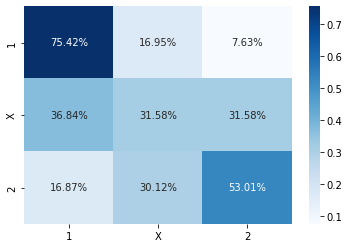

In [275]:
# soronként, azaz az eredeti osztályozás szerint
sns.heatmap(cf_matrix/np.repeat(np.sum(cf_matrix, axis=1), 3).reshape(3, 3), annot=True, fmt='.2%', cmap='Blues', xticklabels=['1', 'X', '2'], yticklabels=['1', 'X', '2'])

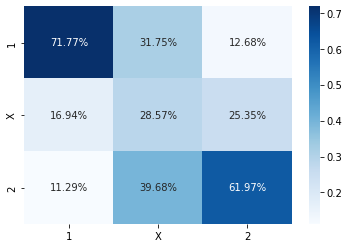

In [276]:
# oszloponként, azaz a predikció szerint
sns.heatmap(cf_matrix/np.repeat([np.sum(cf_matrix, axis=0)], 3, axis=0), annot=True, fmt='.2%', cmap='Blues', xticklabels=['1', 'X', '2'], yticklabels=['1', 'X', '2'])

### Eredmények a statisztikák, majd abból az eredmények tanulása után

In [278]:
def stat_results(stat_number,  clf_loc, stats_loc=stats, matches_stat_loc=matches_stat):
  clf=stat_fit_model(stat_number,  clf_loc, stats_locc=stats_loc, matches_stat_locc=matches_stat_loc)
  X_stat_test, y_stat_test, _ = stat_generator_test(stat_number)
  y_pred=clf.predict(X_stat_test)
  return y_pred

In [281]:
list_of_stats=[]
list_of_stats_names=[]
for stat_number in stat_list:
  list_of_stats.append(list(stat_results(stat_number, GradientBoostingRegressor(loss = 'ls', max_depth = 10))))
  list_of_stats_names.append(stats[stat_number])

In [284]:
stat_df = pd.DataFrame(list(zip(*list_of_stats)), columns=list_of_stats_names)
stat_df

,home_corner,away_corner,home_pass,away_pass,home_duel,away_duel,home_foul,away_foul,home_save attempt,away_save attempt,...,home_possession,away_possession,home_degree,away_degree,home_diameter,away_diameter,home_bet_cent,away_bet_cent,home_entropy,away_entropy
0,5.496331,4.581043,555.118222,399.388789,231.893399,203.980599,10.933714,13.973010,3.026670,5.307247,...,0.599618,0.386416,38.812644,28.176304,2.079020,2.106385,0.017110,0.020270,0.027311,0.063227
1,5.670045,3.043736,529.145671,397.159032,199.219861,210.759848,16.322137,11.612187,3.479381,8.214292,...,0.544233,0.509893,40.121543,35.147487,2.079020,2.101792,0.020685,0.022050,0.040020,0.051143
2,4.858710,4.517190,510.545079,398.155716,216.270192,216.987209,12.706924,15.959548,3.053141,4.607897,...,0.626430,0.413993,37.004874,30.196152,2.079020,2.171333,0.014444,0.024475,0.029720,0.051408
3,5.380485,3.808457,580.871020,283.172168,211.263964,233.451529,12.745699,12.704496,3.560455,6.062561,...,0.644933,0.407549,43.063776,27.019569,2.079020,2.166508,0.014517,0.035583,0.030390,0.079702
4,5.724099,5.747023,488.749929,406.731199,217.354726,223.004813,13.724600,15.746865,4.693972,4.293588,...,0.537018,0.505502,35.129426,33.854201,2.079020,2.200199,0.024437,0.021530,0.033282,0.050755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
511,4.600593,4.774298,287.522993,628.388587,223.571930,225.760693,8.359367,12.313113,8.092700,2.488042,...,0.334802,0.669985,18.274144,46.568436,2.138455,2.218363,0.035481,0.016766,0.071203,0.026439
512,5.622024,4.344289,345.201982,488.170579,241.179500,230.053141,10.367142,9.839786,6.340488,4.377798,...,0.473701,0.551677,22.486877,35.184308,2.103361,2.111033,0.029326,0.022991,0.084999,0.033949
513,4.922211,6.271558,375.895348,433.085581,244.612410,226.260455,10.874585,11.338632,5.311046,4.776824,...,0.461899,0.514250,27.073254,29.909159,2.499884,2.495011,0.028878,0.022562,0.063021,0.048915
514,2.985168,4.944071,371.877268,437.700227,255.490318,249.333896,14.479953,13.089773,5.489958,2.807381,...,0.477355,0.539977,26.897264,32.942382,2.087071,2.105335,0.021048,0.021426,0.044350,0.041839


In [283]:
matches_test_helper=pd.DataFrame(matches_check_test).reset_index(drop=True)
matches_test_helper

,home,away,gameweek,home_goal,away_goal,home_corner,away_corner,home_pass,away_pass,home_duel,...,home_possession,away_possession,home_degree,away_degree,home_diameter,away_diameter,home_bet_cent,away_bet_cent,home_entropy,away_entropy
0,AC Milan,Torino,33,1,1,6,6,469,437,193,...,0.53,0.47,37.364,30.000,2,2,0.020,0.032,0.035,0.050
1,AC Milan,Benevento,34,0,1,4,1,563,329,235,...,0.63,0.37,43.364,23.636,2,2,0.024,0.018,0.029,0.058
2,AC Milan,Bologna,35,2,1,1,7,492,423,171,...,0.54,0.46,38.727,31.455,2,2,0.025,0.015,0.034,0.040
3,AC Milan,Verona,36,4,1,5,4,639,387,179,...,0.61,0.39,51.818,30.636,2,2,0.014,0.016,0.022,0.041
4,AC Milan,Atalanta,37,1,1,8,3,419,427,208,...,0.51,0.49,32.000,31.909,2,2,0.015,0.026,0.040,0.044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
511,West Ham,Manchester City,36,1,4,0,7,260,860,181,...,0.26,0.74,17.182,70.636,2,2,0.038,0.012,0.101,0.015
512,West Ham,Leicester,37,2,0,3,8,354,409,233,...,0.47,0.53,24.909,29.182,3,2,0.030,0.017,0.062,0.044
513,West Ham,Everton,38,3,1,6,6,448,341,184,...,0.57,0.43,34.636,25.273,2,2,0.019,0.025,0.037,0.057
514,Wolfsburg,RB Leipzig,33,1,4,5,2,387,345,216,...,0.52,0.48,27.091,23.727,2,2,0.024,0.028,0.051,0.061


In [288]:
stat_df[['home', 'away', 'gameweek', 'home_goal', 'away_goal', 'home_odds', 'away_odds']]=matches_test_helper[['home', 'away', 'gameweek', 'home_goal', 'away_goal', 'home_odds', 'away_odds']]

In [289]:
stat_df

,home_corner,away_corner,home_pass,away_pass,home_duel,away_duel,home_foul,away_foul,home_save attempt,away_save attempt,...,away_bet_cent,home_entropy,away_entropy,home,away,gameweek,home_goal,away_goal,home_odds,away_odds
0,5.496331,4.581043,555.118222,399.388789,231.893399,203.980599,10.933714,13.973010,3.026670,5.307247,...,0.020270,0.027311,0.063227,AC Milan,Torino,33,1,1,2.37,3.13
1,5.670045,3.043736,529.145671,397.159032,199.219861,210.759848,16.322137,11.612187,3.479381,8.214292,...,0.022050,0.040020,0.051143,AC Milan,Benevento,34,0,1,1.23,13.60
2,4.858710,4.517190,510.545079,398.155716,216.270192,216.987209,12.706924,15.959548,3.053141,4.607897,...,0.024475,0.029720,0.051408,AC Milan,Bologna,35,2,1,1.66,5.58
3,5.380485,3.808457,580.871020,283.172168,211.263964,233.451529,12.745699,12.704496,3.560455,6.062561,...,0.035583,0.030390,0.079702,AC Milan,Verona,36,4,1,1.12,22.62
4,5.724099,5.747023,488.749929,406.731199,217.354726,223.004813,13.724600,15.746865,4.693972,4.293588,...,0.021530,0.033282,0.050755,AC Milan,Atalanta,37,1,1,4.01,2.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
511,4.600593,4.774298,287.522993,628.388587,223.571930,225.760693,8.359367,12.313113,8.092700,2.488042,...,0.016766,0.071203,0.026439,West Ham,Manchester City,36,1,4,9.27,1.34
512,5.622024,4.344289,345.201982,488.170579,241.179500,230.053141,10.367142,9.839786,6.340488,4.377798,...,0.022991,0.084999,0.033949,West Ham,Leicester,37,2,0,3.27,2.28
513,4.922211,6.271558,375.895348,433.085581,244.612410,226.260455,10.874585,11.338632,5.311046,4.776824,...,0.022562,0.063021,0.048915,West Ham,Everton,38,3,1,2.33,3.22
514,2.985168,4.944071,371.877268,437.700227,255.490318,249.333896,14.479953,13.089773,5.489958,2.807381,...,0.021426,0.044350,0.041839,Wolfsburg,RB Leipzig,33,1,4,4.69,1.73


In [292]:
stat_df=stat_df[list(train_df.columns)]
stat_df

,home,away,home_goal,away_goal,gameweek,home_corner,away_corner,home_pass,away_pass,home_duel,...,home_possession,away_possession,home_degree,away_degree,home_diameter,away_diameter,home_bet_cent,away_bet_cent,home_entropy,away_entropy
0,AC Milan,Torino,1,1,33,5.496331,4.581043,555.118222,399.388789,231.893399,...,0.599618,0.386416,38.812644,28.176304,2.079020,2.106385,0.017110,0.020270,0.027311,0.063227
1,AC Milan,Benevento,0,1,34,5.670045,3.043736,529.145671,397.159032,199.219861,...,0.544233,0.509893,40.121543,35.147487,2.079020,2.101792,0.020685,0.022050,0.040020,0.051143
2,AC Milan,Bologna,2,1,35,4.858710,4.517190,510.545079,398.155716,216.270192,...,0.626430,0.413993,37.004874,30.196152,2.079020,2.171333,0.014444,0.024475,0.029720,0.051408
3,AC Milan,Verona,4,1,36,5.380485,3.808457,580.871020,283.172168,211.263964,...,0.644933,0.407549,43.063776,27.019569,2.079020,2.166508,0.014517,0.035583,0.030390,0.079702
4,AC Milan,Atalanta,1,1,37,5.724099,5.747023,488.749929,406.731199,217.354726,...,0.537018,0.505502,35.129426,33.854201,2.079020,2.200199,0.024437,0.021530,0.033282,0.050755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
511,West Ham,Manchester City,1,4,36,4.600593,4.774298,287.522993,628.388587,223.571930,...,0.334802,0.669985,18.274144,46.568436,2.138455,2.218363,0.035481,0.016766,0.071203,0.026439
512,West Ham,Leicester,2,0,37,5.622024,4.344289,345.201982,488.170579,241.179500,...,0.473701,0.551677,22.486877,35.184308,2.103361,2.111033,0.029326,0.022991,0.084999,0.033949
513,West Ham,Everton,3,1,38,4.922211,6.271558,375.895348,433.085581,244.612410,...,0.461899,0.514250,27.073254,29.909159,2.499884,2.495011,0.028878,0.022562,0.063021,0.048915
514,Wolfsburg,RB Leipzig,1,4,33,2.985168,4.944071,371.877268,437.700227,255.490318,...,0.477355,0.539977,26.897264,32.942382,2.087071,2.105335,0.021048,0.021426,0.044350,0.041839


In [293]:
y_home_true=matches_test_helper['home_goal'].values
y_home_pred=clf_home.predict(stat_df.iloc[:,5:].values)

In [294]:
y_away_true=matches_test_helper['away_goal'].values
y_away_pred=clf_away.predict(stat_df.iloc[:,5:].values)

In [295]:
# az eredmények confusion matrix-a
cf_matrix=metrics.confusion_matrix(result(stat_df.iloc[:,2],stat_df.iloc[:,3]), result(np.round(y_home_pred), np.round(y_away_pred)), labels=['1', 'X', '2'])
cf_matrix

array([[78, 88, 35],
       [27, 55, 32],
       [26, 82, 93]])

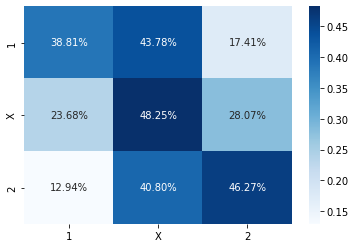

In [296]:
# soronként, azaz az eredeti osztályozás szerint
sns.heatmap(cf_matrix/np.repeat(np.sum(cf_matrix, axis=1), 3).reshape(3, 3), annot=True, fmt='.2%', cmap='Blues', xticklabels=['1', 'X', '2'], yticklabels=['1', 'X', '2'])

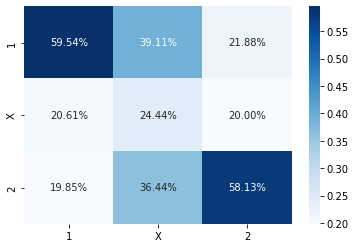

In [297]:
# oszloponként, azaz a predikció szerint
sns.heatmap(cf_matrix/np.repeat([np.sum(cf_matrix, axis=0)], 3, axis=0), annot=True, fmt='.2%', cmap='Blues', xticklabels=['1', 'X', '2'], yticklabels=['1', 'X', '2'])